# Problem Statement

## Business Problem Statement

Sebuah bank perlu untuk memahami perilaku customer dalam penggunaan produk bank agar dapat meningkatkan revenue bisnis bank tersebut. Bank harus dapat mengaplikasikan strategi marketing yang tepat pada customer yang tepat agar tujuan tercapai dengan efektif. Jumlah customer bank yang banyak dapat dikelompokkan ke dalam beberapa kategori perilaku berdasarkan kemiripan karakteristik customer, dalam hal ini pada penggunaan kartu kredit. Hal ini dilakukan untuk mempermudah analisa segmentasi tiap customer dan pengambilan keputusan strategi marketing yang tepat, misalnya penawaran kenaikan limit pada eligible customer, penawaran produk banking lain yang pada potential customer, dan lain-lain.

**Problem Statement for Machine Learning :**
- How to predict customer segmentation so we can determine the best marketing strategy to attract customers and promote specific products ?
- value : customer segmentation
- goals : to define marketing strategy

**Problem Statement for Analytics :**
- What customer should we target in order to increase revenue ?
- What marketing strategy should we take in order to increase revenue ?
- action : targeting, marketing strategy
- goals : increase revenue  
     



# Data Understanding

Dataset ini berisikan perilaku 8950 customer aktif dalam menggunakan kartu kredit selama 6 bulan terakhir.

Unit Analysis in each cases :
- Customer : Customer ID
- One row represent a customer

Attributes :  
1. CUSTID : Identifikasi pengguna kartu kredit (Categorical)
2. BALANCE : Jumlah saldo yang terisa di rekening untuk melakukan pembelian
3. BALANCEFREQUENCY : Seberapa sering saldo di-update
    * skor antara 0 dan 1
        - 1 = sering update
        - 0 = tidak sering update        
4. PURCHASES : Jumlah pembelian yang dilakukan
5. ONEOFFPURCHASES : Jumlah pembelian maksimum yang dilakukan dalam sekali jalan
6. INSTALLMENTSPURCHASES : Jumlah pembelian dilakukan secara angsuran
7. CASHADVANCE : Uang tunai di muka yang diberikan ke customer
8. PURCHASESFREQUENCY : Seberapa sering pembelian dilakukan
    * skor antara 0 dan 1
        - 1 = sering melakukan pembelian
        - 0 = tidak sering melakukan pembelian 
9. ONEOFFPURCHASESFREQUENCY : Seberapa sering customer melakukan pembelian yang dilakukan dalam sekali jalan
    * skor antara 0 dan 1
        - 1 = sering melakukan pembelian
        - 0 = tidak sering melakukan pembelian
10. PURCHASESINSTALLMENTSFREQUENCY : Seberapa sering customer melakukan pembelian yang dilakukan secara angsuran 
    * skor antara 0 dan 1
        - 1 = sering melakukan pembelian
        - 0 = tidak sering melakukan pembelian
11. CASHADVANCEFREQUENCY : Seberapa sering customer melakukan tarik uang tunai di muka
12. CASHADVANCETRX : Jumlah transaksi yang dilakukan dengan uang tunai di muka
13. PURCHASESTRX : Jumlah transaksi pembelian yang dilakukan
14. CREDITLIMIT : Limit kartu kredit customer
15. PAYMENTS : Jumlah pembayaran yang dilakukan customer
16. MINIMUM_PAYMENTS : Jumlah minimum pembayaran yang harus dibayar customer
17. PRCFULLPAYMENT : Persentase pembayaran penuh (lunas) oleh customer
18. TENURE : Tenure kartu kredit customer

# Exploratory Data Analysis (EDA)

In [4]:
# data processing
import pandas as pd
import numpy as np
# visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
# scaling
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# statistik
from scipy import stats
# modeling
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward, average, complete

import warnings 
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("CC GENERAL.csv")
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Dalam hal ini dapat dilihat bahwa:
1. Purchase = one off purchase + installments purchase
<br>
2. Customer NPL dikategorikan sebagai customer yang memiliki jumlah payment kurang dari minimum payment

## 1. Identify missing value

In [6]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [7]:
df[df['CREDIT_LIMIT'].isna()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,C15349,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


In [8]:
df[df['MINIMUM_PAYMENTS'].isna()].head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,C10004,1666.670542,0.636364,1499.0,1499.0,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
45,C10047,2242.311686,1.000000,437.0,97.0,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
47,C10049,3910.111237,1.000000,0.0,0.0,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
54,C10056,6.660517,0.636364,310.0,0.0,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
55,C10057,1311.995984,1.000000,1283.9,1283.9,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12


In [9]:
df[(df['MINIMUM_PAYMENTS'].isna())&(df['PURCHASES']==0)&(df['CASH_ADVANCE']==0)]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


Melihat data missing value, dalam hal ini:
1. Data customer dengan missing value credit limit akan di drop karena jumlah sangat sedikit (1 data) dan missing value tidak dapat didefinisikan. Hal ini kemungkinan besar disebabkan oleh error pada pengisian data.

2. Data customer dengan missing value minimum payments akan di drop karena tidak dapat didefinisikan. Berdasar teori perbankan, pada umumnya minimum payments didefinisikan dari persentase minimal yang harus dibayar sesuai pembelajaan (purchase/cash advance) per bulan berserta rate bunga dari tagihan yang belum terbayar sebelumnya. Pada data ini, data hanya mencakup ringkasan aktifitas selama 6 bulan, sehingga tidak diketahui pembayaran dan sisa tagihan pada bulan-bulan sebelumnya. Oleh karena itu, untuk menghindari kesalahan pengisian yang dapat menyebabkan kesalahan analisis modeling, akan dilakukan penghilangan data customer yang memiliki data kosong pada minimum paymentsnya.

In [10]:
df.dropna(inplace=True)

In [11]:
df

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8943,C19184,5.871712,0.500000,20.90,20.90,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,1,500.0,58.644883,43.473717,0.000000,6
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


## Define Dataframe for NPL customer and target customer

In [12]:
df_npl = df[df['PAYMENTS']<df['MINIMUM_PAYMENTS']]

df_target = df[df['PAYMENTS']>=df['MINIMUM_PAYMENTS']]

print("shape df npl: ",df_npl.shape)

print("shape df target: ",df_target.shape)

shape df npl:  (2364, 18)
shape df target:  (6272, 18)


In [13]:
df_npl.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2,C10003,2495.148862,1.0,773.17,773.17,0.00,0.000000,1.000000,1.0,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.0,12
5,C10006,1809.828751,1.0,1333.28,0.00,1333.28,0.000000,0.666667,0.0,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.0,12
10,C10011,1293.124939,1.0,920.12,0.00,920.12,0.000000,1.000000,0.0,1.000000,0.000000,0,12,1200.0,1083.301007,2172.697765,0.0,12
14,C10015,2772.772734,1.0,0.00,0.00,0.00,346.811390,0.000000,0.0,0.000000,0.083333,1,0,3000.0,805.647974,989.962866,0.0,12
15,C10016,6886.213231,1.0,1611.70,0.00,1611.70,2301.491267,0.500000,0.0,0.500000,0.166667,4,11,8000.0,1993.439277,2109.906490,0.0,12


In [14]:
df_target.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.00,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.00,0,12,2300.0,679.065082,532.033990,0.000000,12


In [15]:
df_npl.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [16]:
df_target.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

## 2. Identify duplicate value

In [17]:
# Cek duplikasi data
df.duplicated().any()

False

Tidak terdapat duplikasi pada data

## 3. Data Correlation

Melihat korelasi antar fitur dari:
1. Dataframe awal
2. Dataframe pada customer NPL
3. Dataframe pada customer target

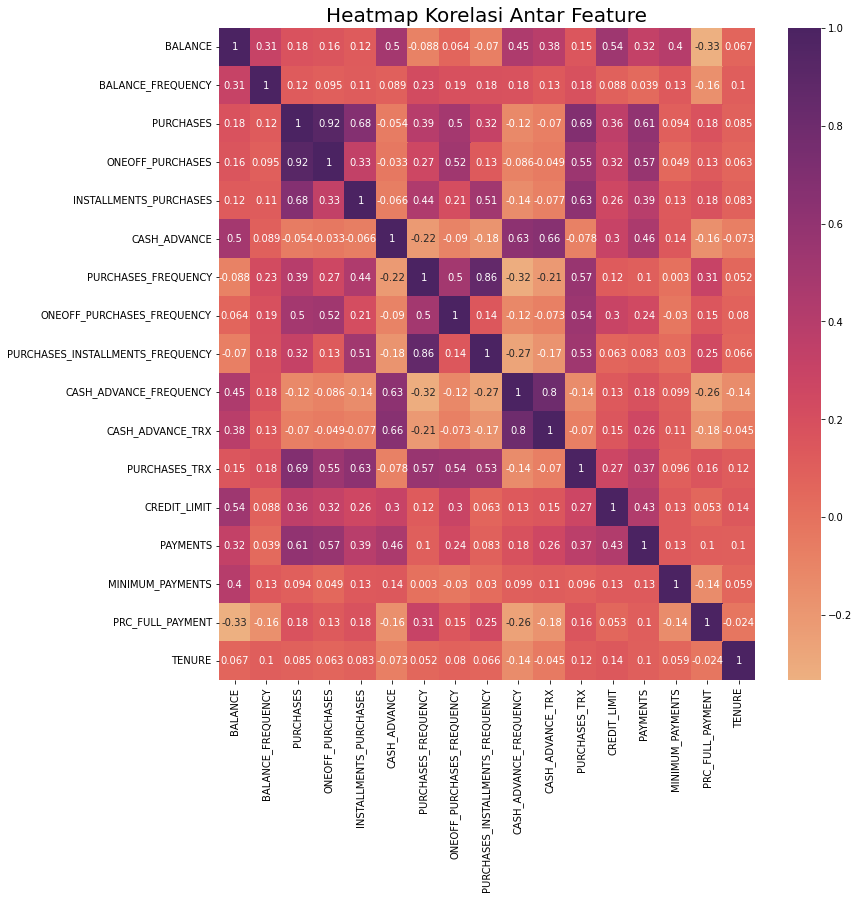

In [18]:
# 1. Dataframe awal

feature = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
dfcorr = df[feature].corr()

plt.figure(figsize=(12,12))
sns.heatmap(dfcorr, annot=True, cmap='flare')
plt.title('Heatmap Korelasi Antar Feature', size=20)
plt.show()

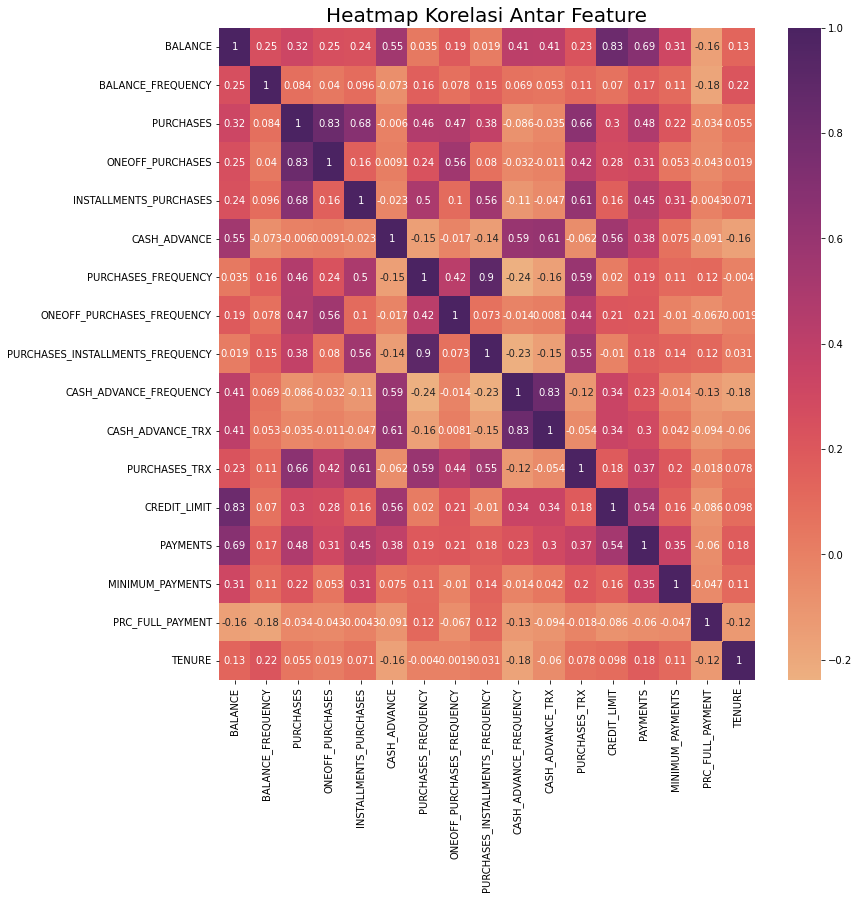

In [19]:
# 2. Dataframe customer NPL

feature = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
dfcorr = df_npl[feature].corr()

plt.figure(figsize=(12,12))
sns.heatmap(dfcorr, annot=True, cmap='flare')
plt.title('Heatmap Korelasi Antar Feature', size=20)
plt.show()

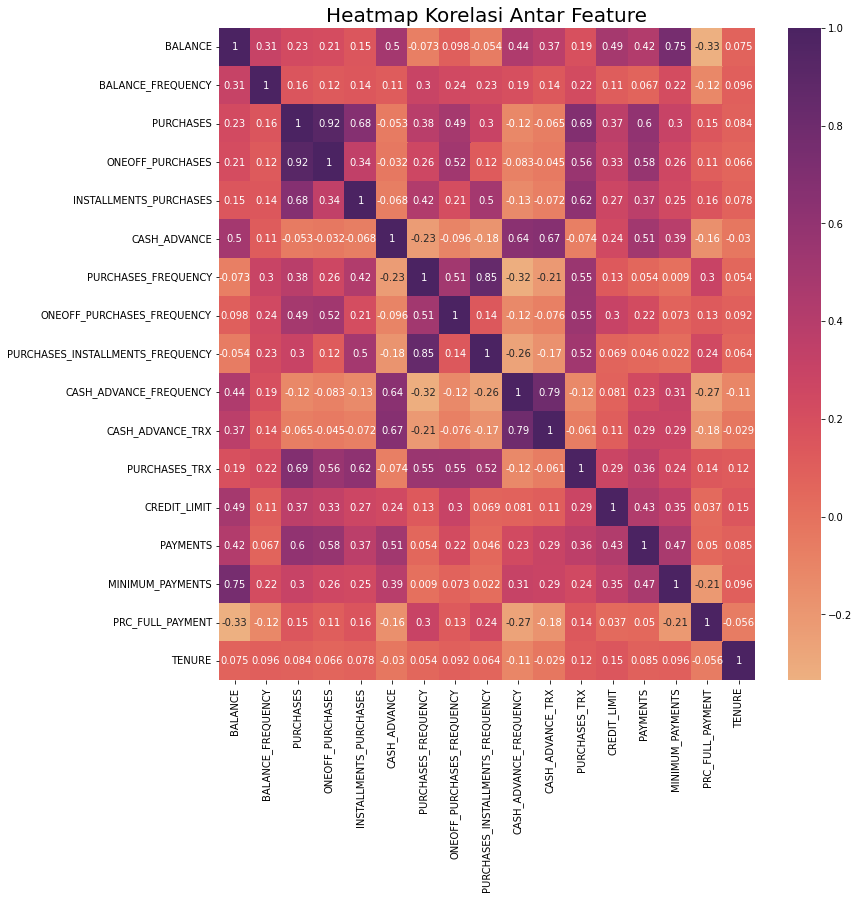

In [20]:
# 3. Dataframe customer target

feature = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
dfcorr = df_target[feature].corr()

plt.figure(figsize=(12,12))
sns.heatmap(dfcorr, annot=True, cmap='flare')
plt.title('Heatmap Korelasi Antar Feature', size=20)
plt.show()

Berdasar ketiga tabel diatas tidak ada perbedaan yang signifikan korelasi fitur-fitur baik pada data awal, dengan data pada customer NPL, dan data pada customer target.
<br><br>
Melihat definisi tiap fitur serta berdasar tabel korelasi, dalam hal ini akan dipilih beberapa fitur yang sekiranya memiliki peran penting dalam clustering. Pemilihan ini bertujuan agar tidak terlalu banyak fitur yang digunakan sebagai dasar segmentasi.
<br><br>
Berikut yang akan dilakukan:
1. Fitur yang secara definisi dan teori tidak terlalu penting untuk dipertimbangkan.
1. Fitur yang secara definisi tergolong dalam satu area dan memiliki korelasi yang tinggi akan dipilih salah satu saja dengan asumsi bahwa fitur-fitur tsb tidak terlalu merubah pengkategorisasian customer.
2. Fitur yang secara keseluruhan memiliki nilai korelasi sangat rendah dengan fitur-fitur lainnya tidak perlu digunakan. Hal tersebut menunjukkan bahwa fitur tidak memiliki pola pendefinisian berdasar fitur-fitur lain atau dapat dikatakan memiliki faktor lain dalam penentuan pengisiannya sehingga tidak terlalu signifikan apabila digunakan sebagai kategorisasi bersamaan dengan fitur-fitur lain yang memiliki korelasi satu sama lain yang lebih tinggi. 
<br><br>
Fitur-fitur yang akan dipilih antara lain:
<br>
'BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'

## 4. Data Distribution and outlier

In [21]:
feature= ['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
          'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']

df_copy=df.copy()
df_npl_copy=df_npl.copy()
df_target_copy=df_target.copy()

df=df[feature]
df_npl=df_npl[feature]
df_target=df_target[feature]

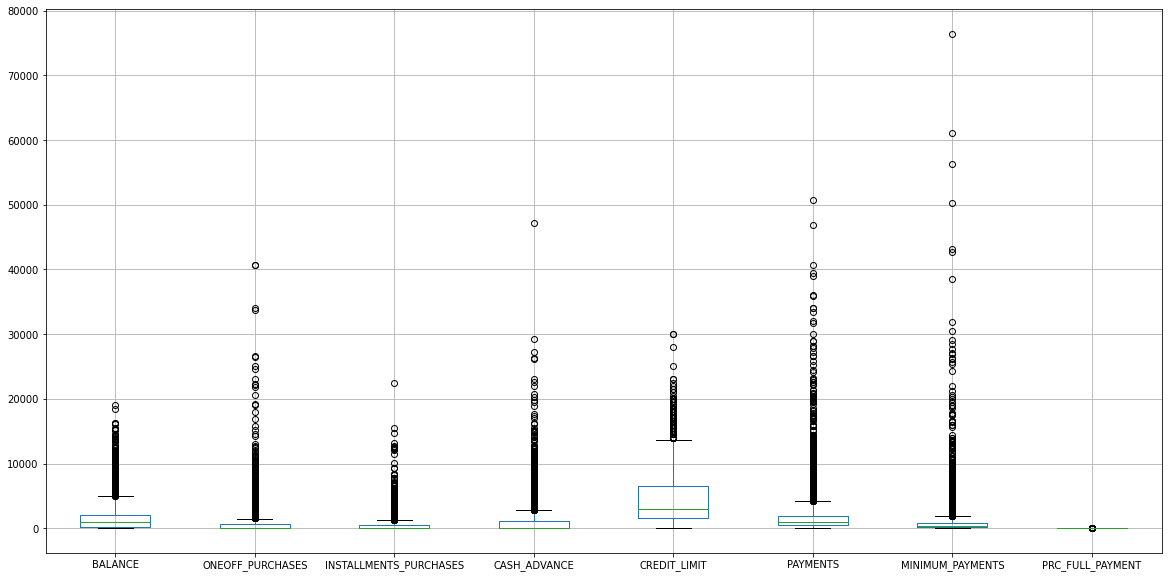

In [22]:
df.boxplot(figsize = (20,10))
plt.show()

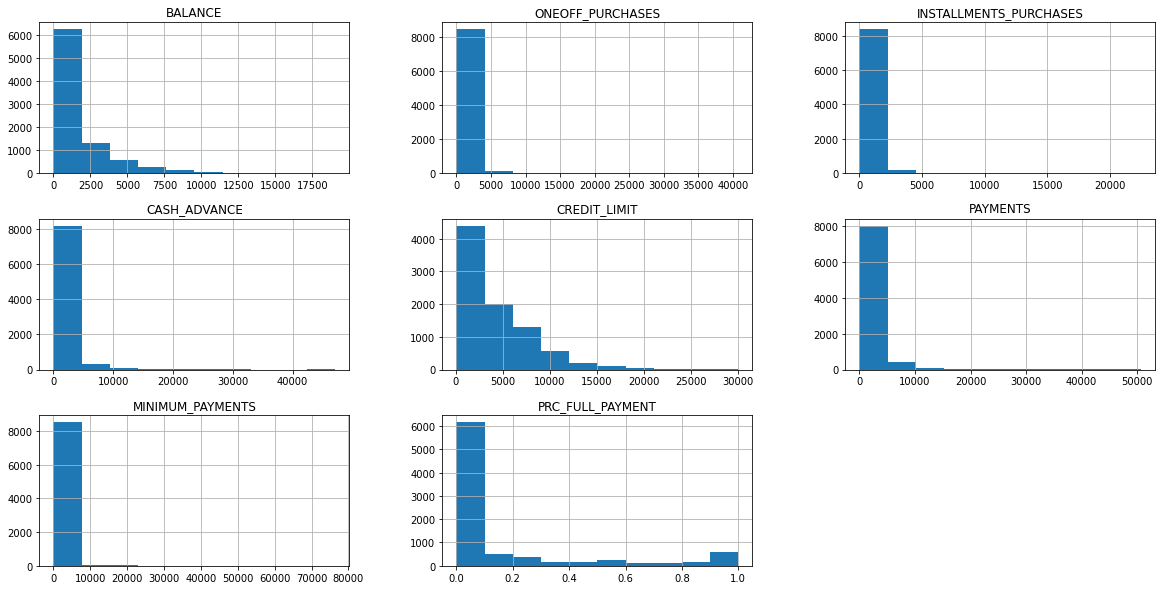

In [23]:
df.hist(figsize = (20,10))
plt.show()

Berdasarkan grafik tersebut dapat dilihat bahwa jumlah outlier pada data ini tergolong cukup besar. Dalam hal ini akan dilakukan normalisasi pada data dengan melakukan teknik scaling

# Preprocessing

Di tahap preprocessing akan dilakukan scaling, sebelumnya di bagian EDA telah dilakukan juga preprocessing terkait missing value (drop)

## Scaling

Pada tahap ini akan dilakukan perbandingan teknik scaling untuk menentukan scaling mana yang paling tepat dalam normalisasi data customer target. Karena modeling akan dilakukan dengan PCA dan K-Means, maka evaluasi dilakukan dengan cara melihat score persentase tertinggi pada variasi yang dapat dijelaskan melalui jumlah PCA sebanyak 2. 

In [24]:
options = [MinMaxScaler, StandardScaler, RobustScaler]

var = 0.9
pca = PCA(n_components=var, svd_solver='full')

for name_scaler in options:
    scaler = name_scaler() 
    scaled = scaler.fit_transform(df_target.values)
    
    pca_values = pca.fit_transform(scaled)
    print(f"{name_scaler.__name__}\nOptimal number: {pca.n_components_}\nVariance: {np.sum(pca.explained_variance_ratio_)}\n")

MinMaxScaler
Optimal number: 2
Variance: 0.9021092727857379

StandardScaler
Optimal number: 6
Variance: 0.9525525928249197

RobustScaler
Optimal number: 5
Variance: 0.9368597777582229



Berdasar hasil iterasi kode di atas, ditemukan bahwa :
1. Standard Scaler:  
Total variasi yang dapat dijelaskan dengan 2 garis PCA adalah : 59.88%
1. Robust scaler:   
Total variasi yang dapat dijelaskan dengan 2 garis PCA adalah : 68.43%
1. Min max scaler:  
Total variasi yang dapat dijelaskan dengan 2 garis PCA adalah : 90.21%

<br>

Oleh karena itu, teknik scaling yang akan dipilih adalah menggunakan min max scaler.

In [25]:
df_scaled_minmax = pd.DataFrame(MinMaxScaler().fit_transform(df_target), columns=df_target.columns)

In [26]:
df_scaled_minmax.head()

,BALANCE,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
0,0.002148,0.000000,0.004240,0.000000,0.031720,0.003978,0.007491,0.000000
1,0.168169,0.000000,0.000000,0.136685,0.232053,0.080892,0.057587,0.222222
2,0.042940,0.000393,0.000000,0.000000,0.038397,0.013373,0.013145,0.000000
3,0.032939,0.157076,0.030595,0.000000,0.449082,0.125278,0.010636,1.000000
4,0.095764,0.000000,0.019387,0.000000,0.075125,0.013387,0.028571,0.000000


In [27]:
df_scaled_minmax.describe()

,BALANCE,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
count,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000
mean,0.065666,0.017781,0.021721,0.019529,0.156385,0.042357,0.025536,0.213958
std,0.096996,0.046646,0.044424,0.046837,0.125144,0.064775,0.040675,0.327054
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.004704,0.000000,0.000000,0.000000,0.058431,0.010375,0.008251,0.000000
50%,0.027875,0.002232,0.007266,0.000000,0.115192,0.022573,0.011504,0.000000
75%,0.083731,0.018773,0.025866,0.019635,0.215359,0.047735,0.028046,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Modeling

### PCA

Pada tahap ini akan dilakukan PCA untuk melihat kelompok fitur yang mewakili 8 fitur dengan cara mengkombinasikan fitur-fitur yang informasinya sejenis. PCA akan menghasilkan garis-garis komponen yang akan memperlihatkan seberapa besar jumlah variasi yang merepresentasikan fitur-fitur awal yang kita punya.

In [28]:
pca = PCA(n_components=8, random_state=10).fit(df_scaled_minmax)
pca_data = pca.transform(df_scaled_minmax) 
pca_labels = ['PC' + str(component) for component in range(1,len(pca.components_)+1)]
pca_df = pd.DataFrame(pca_data, columns=pca_labels)
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.206781,-0.158689,-0.005118,0.013023,-0.002359,-0.001024,0.003423,-0.001118
1,-0.006386,0.135809,0.068245,-0.042461,0.085296,0.011329,-0.013716,-0.028098
2,-0.211261,-0.130744,0.020215,-0.000892,-0.007747,-0.008038,0.001342,0.010197
3,0.790666,0.288362,-0.106589,0.067369,-0.007757,-0.082611,-0.013217,-0.017329
4,-0.216590,-0.072042,0.035344,-0.022450,-0.028966,0.003104,-0.001684,0.011529
...,...,...,...,...,...,...,...,...
6267,0.786424,-0.107203,0.082132,-0.046777,-0.011940,0.003374,-0.007225,0.003958
6268,-0.243049,0.236018,0.088932,-0.136585,0.065248,0.014888,-0.082861,-0.049102
6269,0.041579,-0.148162,0.014150,-0.005069,-0.002918,-0.003623,-0.000231,-0.000233
6270,-0.206701,-0.174682,0.001455,0.012303,-0.001470,-0.004937,-0.000752,0.000243


In [29]:
explained_var_ratio_per_PCA = np.round(pca.explained_variance_ratio_ * 100, decimals=1) 
explained_var_ratio_per_PCA_df = pd.DataFrame(pca.explained_variance_ratio_ * 100, index= pca_labels)
explained_var_ratio_per_PCA_df

,0
PC1,75.124957
PC2,15.085970
PC3,4.060170
PC4,2.497021
PC5,1.543529
PC6,0.938807
PC7,0.418329
PC8,0.331217


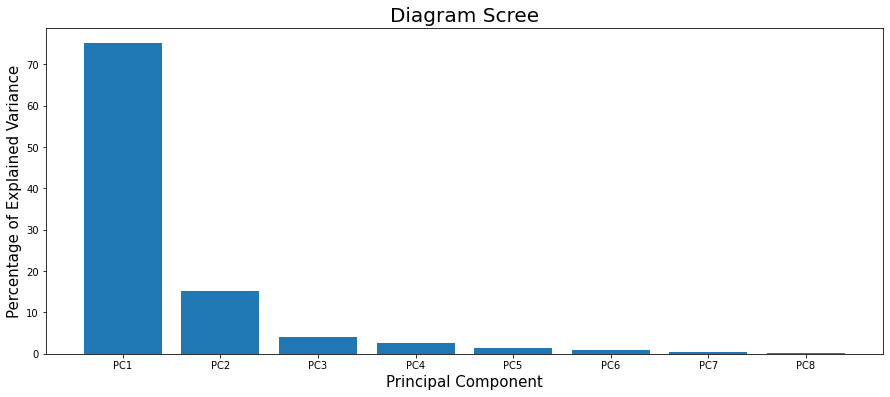

In [30]:
fig = plt.figure(figsize=(15,6))
plt.bar(x=range(1, len(explained_var_ratio_per_PCA)+1), height=explained_var_ratio_per_PCA, tick_label=pca_labels)
plt.ylabel('Percentage of Explained Variance', fontsize=15)
plt.xlabel('Principal Component', fontsize=15)
plt.title('Diagram Scree', fontsize=20)
plt.show()

In [31]:
print(f"Total variasi yang dapat dijelaskan dengan PC1 dan PC2 adalah :{pca.explained_variance_ratio_[:2].sum()*100}")

Total variasi yang dapat dijelaskan dengan PC1 dan PC2 adalah :90.21092727857379


Diagram Scree diatas menunjukkan prosentase variasi yang dapat dijelaskan oleh 8 komponen utama yang terbentuk dari PCA. Dapat dilihat bahwa Principal Komponen 1 (PC1) dan Principal Komponen 2 (PC2) sudah dapat menjelaskan lebih dari 90% variasi yang ada. Oleh karena itu, hanya kedua komponen tersebut yang akan dianalisa lebih lanjut. Hal ini juga dikarenakan agar sebaran data cluster dapat dilihat menggunakan grafik dengan lebih mudah.

### K-Means Clustering

Kedua garis komponen tersebut akan dianalisa lebih lanjut dengan menggunakan algoritma K-Means. Tujuan algoritma ini adalah untuk mencari pusat data pada kedua garis komponen tersebut (centroid). Jika centroid sudah diketahui maka kita dapat mencari cluster data di kedua garis komponen tersebut.

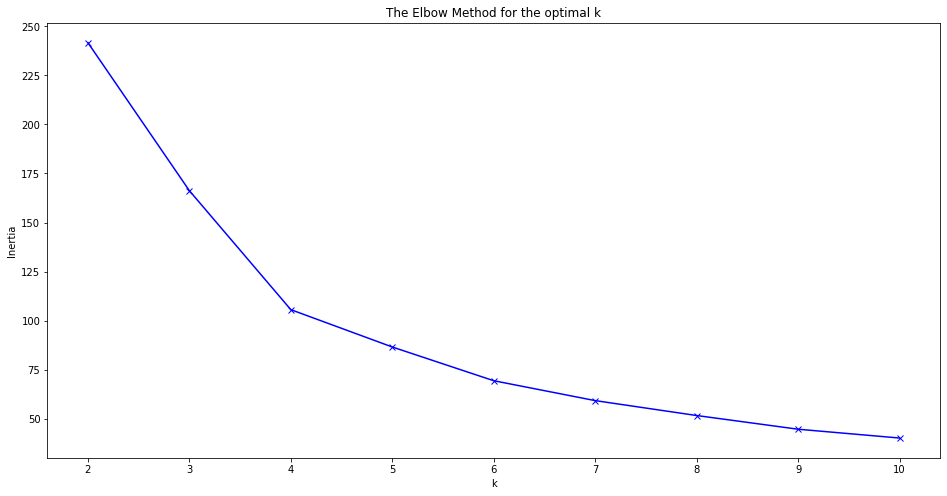

In [32]:
pca_clusters = pd.DataFrame(pca_df[['PC1','PC2']])

# Cari skor inertia dengan elbow method untuk ukur k terbaik cluster 

inertia = []
K = np.arange(2,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=8)
    kmeanModel.fit(pca_clusters)
    inertia.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method for the optimal k')
plt.show()

Skor inertia menunjukkan seberapa jauh tiap datapoin dalam satu cluster yang sama. Semakin kecil skor perbedaan maka semakin baik cluster yang terbentuk.
Terlihat bahwa perubahan skor inertia mulai tidak terlalu signifikan pada cluster 4. Oleh karena itu jumlah cluster 4 merupakan jumlah yang optimal.

In [33]:
# Evaluasi menggunakan silhouette score

silhouette_scores = []
number_of_cluster = range(2,11)

for i in number_of_cluster:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pca_clusters)

  labels = kmeans.labels_
  silhouette_scores.append(silhouette_score(pca_clusters, labels, metric = 'euclidean'))

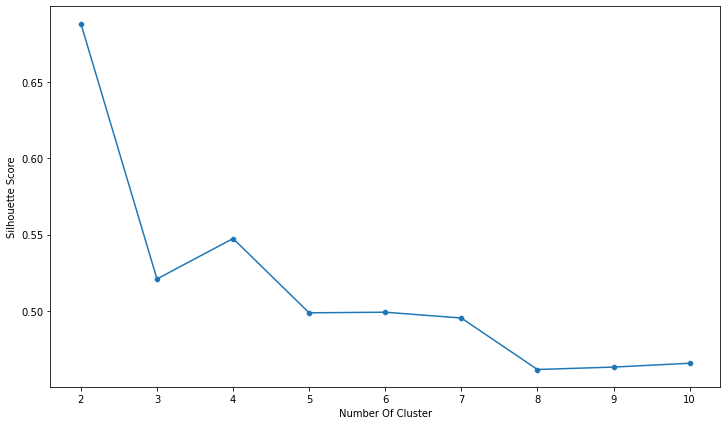

In [34]:
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster, silhouette_scores)
sns.scatterplot(number_of_cluster, silhouette_scores)

plt.xticks(number_of_cluster)

plt.xlabel('Number Of Cluster')
plt.ylabel('Silhouette Score')
plt.show()

Silhouette score menunjukkan seberapa berbeda datapoin terhadap datapoin lain di cluster yang berbeda. Semakin tinggi skor maka cluster semakin berbeda satu sama lain.
Berdasar grafik di atas K cluster yang terbaik yaitu 2, namun mempertimbangkan skor inertia K=2 sangat tinggi (jarak tiap data poin dalam 1 cluster sangat jauh). Dengan mempertimbangkan skor inertia, K yang dipilih adalah 4 karena nilai silhouette score cukup tinggi dibandingkan pada K cluster lainnya.

In [35]:
k_means_clusters = KMeans(n_clusters=4,random_state=8).fit(pca_clusters)

cluster_pusat = k_means_clusters.cluster_centers_
cluster_preds = k_means_clusters.predict(pca_clusters)

In [36]:
# melihat centroid tiap cluster
cluster_pusat

array([[-0.1786106 , -0.06468761],
       [ 0.69608428,  0.0221797 ],
       [-0.20023722,  0.23789155],
       [ 0.2057632 , -0.03881324]])

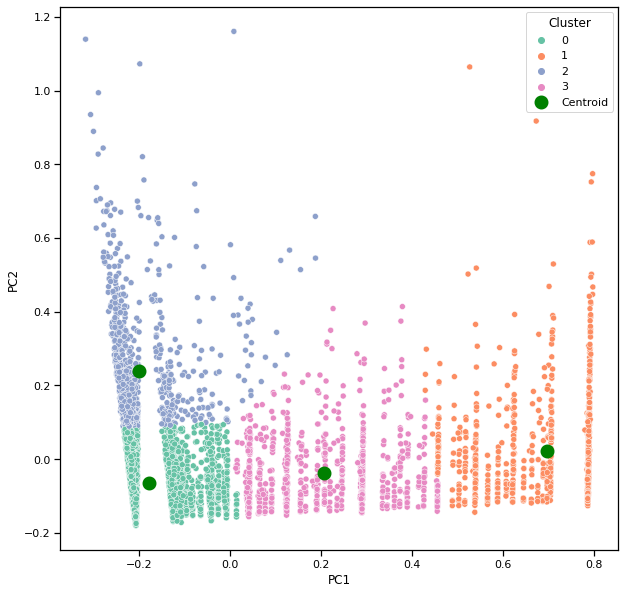

In [37]:
pca_clusters['cluster'] = cluster_preds

plt.figure(figsize=(10,10))
sns.set_context(context = 'notebook', font_scale=1)

sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'cluster', data = pca_clusters, palette='Set2')
plt.scatter(cluster_pusat[:,0],cluster_pusat[:,1], marker = "o", s=80, linewidths = 5, zorder = 10, c='green',label="Centroid")

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Cluster")
plt.show()

In [38]:
df_scaled_minmax_copy = df_scaled_minmax.copy()
df_scaled_minmax_copy['cluster'] = cluster_preds
df_scaled_minmax_copy['cluster'].value_counts(sort=False)

0    3484
1     928
2    1001
3     859
Name: cluster, dtype: int64

In [39]:
cluster_0 = df_scaled_minmax_copy[df_scaled_minmax_copy['cluster']==0].drop('cluster', axis=1).mean()
cluster_1 = df_scaled_minmax_copy[df_scaled_minmax_copy['cluster']==1].drop('cluster', axis=1).mean()
cluster_2 = df_scaled_minmax_copy[df_scaled_minmax_copy['cluster']==2].drop('cluster', axis=1).mean()
cluster_3 = df_scaled_minmax_copy[df_scaled_minmax_copy['cluster']==3].drop('cluster', axis=1).mean()

In [40]:
cluster_0.sort_values(ascending=False)
# selisih besaran pembayaran dibanding minimal pembayaran : 0.073

CREDIT_LIMIT              0.105050
BALANCE                   0.048781
PRC_FULL_PAYMENT          0.032889
PAYMENTS                  0.026874
MINIMUM_PAYMENTS          0.019541
CASH_ADVANCE              0.014191
INSTALLMENTS_PURCHASES    0.012969
ONEOFF_PURCHASES          0.010159
dtype: float64

In [41]:
cluster_1.sort_values(ascending=False)
# selisih besaran pembayaran dibanding minimal pembayaran : 0.036

PRC_FULL_PAYMENT          0.907333
CREDIT_LIMIT              0.177249
PAYMENTS                  0.047593
INSTALLMENTS_PURCHASES    0.037646
ONEOFF_PURCHASES          0.030743
MINIMUM_PAYMENTS          0.011104
BALANCE                   0.010746
CASH_ADVANCE              0.002632
dtype: float64

In [42]:
cluster_2.sort_values(ascending=False)
# selisih besaran pembayaran dibanding minimal pembayaran : 0.024

CREDIT_LIMIT              0.333948
BALANCE                   0.221643
PAYMENTS                  0.096467
MINIMUM_PAYMENTS          0.072022
CASH_ADVANCE              0.062465
ONEOFF_PURCHASES          0.035338
INSTALLMENTS_PURCHASES    0.034682
PRC_FULL_PAYMENT          0.028931
dtype: float64

In [43]:
cluster_3.sort_values(ascending=False)
# selisih besaran pembayaran dibanding minimal pembayaran : 0.025

PRC_FULL_PAYMENT          0.414897
CREDIT_LIMIT              0.135137
PAYMENTS                  0.036447
INSTALLMENTS_PURCHASES    0.024911
ONEOFF_PURCHASES          0.014231
BALANCE                   0.011717
MINIMUM_PAYMENTS          0.011272
CASH_ADVANCE              0.009400
dtype: float64

In [44]:
def buat_radar_chart(dataset, judul):

    rerata_fitur_per_cluster = dataset.groupby("cluster").mean().to_numpy()
    nama_fitur = dataset.columns[0:-1]
    categories = np.arange(0, len(rerata_fitur_per_cluster))
    
    fig = go.Figure()

    for i in range(len(rerata_fitur_per_cluster)):
      fig.add_trace(go.Scatterpolar(
          r=rerata_fitur_per_cluster[i],
          theta=nama_fitur,
          name=f'class {categories[i]}'
      ))

    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[np.min(rerata_fitur_per_cluster), np.max(rerata_fitur_per_cluster)]
        )),
      showlegend=True,
      width = 1000,
      height = 600,
      title = dict(text = f'Feature comparison ({judul})\n',
                   font=dict(size=20))
    )

    fig.show()

buat_radar_chart(df_scaled_minmax_copy, 'Credit Card Dataset')

Dengan analisa lebih lanjut dari kedua Principal Komponen yang dipilih sebelumnya terbentuk 4 cluster dengan pusat seperti terlihat pada scatter plot di atas dengan fitur-fitur pembentuk seperti terlihat pada tabel dan diagram radar di atas. 
<br><br>
Selain itu, akan dilakukan analisis tambahan dengan menggunakan Parallel Coordinates Plot dari setiap data poin sebagai berikut. 

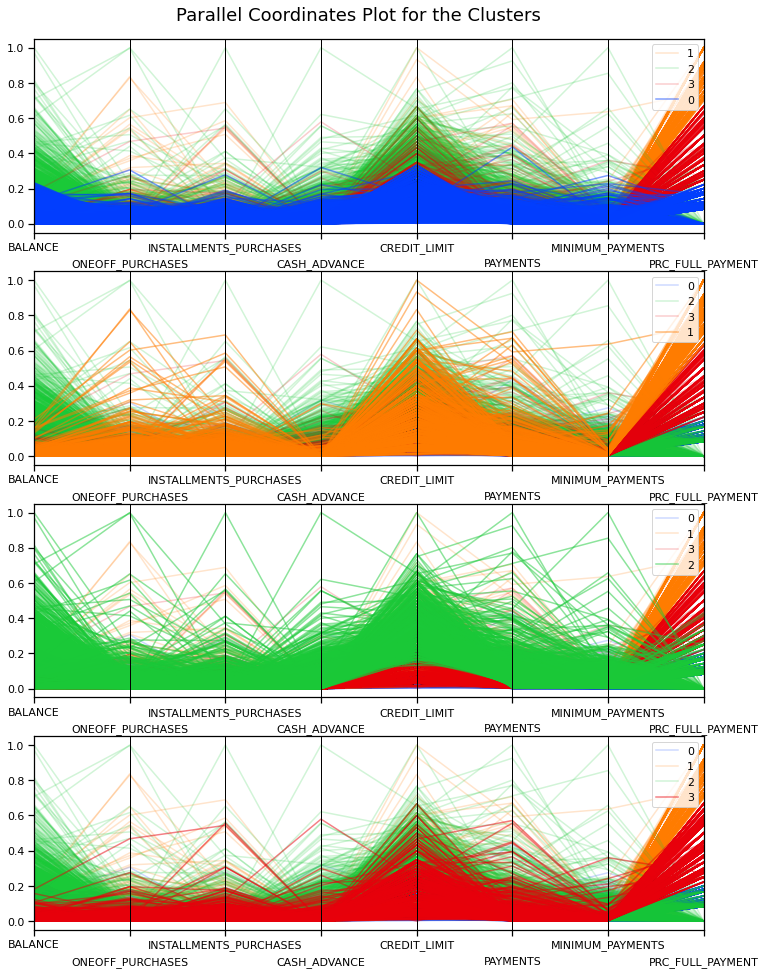

In [85]:
from pandas.plotting import parallel_coordinates
palette = sns.color_palette("bright", 10)

def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)

def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)        

# Display parallel coordinates plots, one for each cluster

display_parallel_coordinates(df_scaled_minmax_copy, 4)

In [48]:
cluster_3.sort_values(ascending=False)

PRC_FULL_PAYMENT          0.414897
CREDIT_LIMIT              0.135137
PAYMENTS                  0.036447
INSTALLMENTS_PURCHASES    0.024911
ONEOFF_PURCHASES          0.014231
BALANCE                   0.011717
MINIMUM_PAYMENTS          0.011272
CASH_ADVANCE              0.009400
dtype: float64

# Conclusion

Berdasar hasil diagram radar dan plot paralel di atas dapat dilihat terdapat 4 cluster yang memiliki karakteristik sebagai berikut,

1. Cluster 0  
  - Cluster ini ditandai dengan aktivitas belanja yang paling tidak aktif (besar) dibandingkan cluster lainnya. 
  - Tergolong cluster customer yang memiliki daya beli cukup rendah ditandai dengan limit yang paling rendah
  - Memiliki rata-rata credit limit cukup tinggi yang tidak jauh berbeda dengan rata-rata balance , menunjukkan adanya sisa saldo yang cukup banyak
  - Pembayaran, minimal pembayaran memiliki perbedaan rata-rata yang cukup besar, sehingga dapat disimpulkan aktifitas cukup normal dan kemampuan bayar tergolong baik. Hal ini juga dilihat melalui rata-rata persentase pembayaran yang langsung dibayar lunas yang tidak terlalu berbeda jauh

1. Cluster 1
  - Cluster ini ditandai dengan aktivitas belanja cukup besar pada one off purchase dan installment, walaupun begitu sangat kecil pada produk cash advance
  - Customer paling sering melakukan pembelian dengan pembayaran lunas dibandingkan ketiga cluster lain. 
  - Walaupun begitu customer terlihat paling besar dalam menggunakan produk installments. Hal ini menandakan customer memakai kartu kredit tetapi seringkali langsung dibayar lunas, dan tidak terlalu suka aktivitas cicilan. Hal ini juga ditandai dengan jumlah minimum payment yang tergolong sangat rendah apabila dibandingkan dengan paymentnya
  - Tergolong cluster customer potensial karena sudah baik dalam hal aktif menggunakan produk dan melakukan pembayaran dengan baik

1. Cluster 2
  - Customer paling aktif dan besar dalam melakukan transaksi pembelian baik one off, installments, dan cash advance. 
  - Terlihat bahwa rata-rata jumlah payment yang tergolong tidak memilik perbedaan yang signifikan dibanding rata-rata jumlah minimum paymentnya
  - Memiliki minimum payments yang sangat tinggi dibandingkan cluster lainnya
  - Memiliki persentase pembayaran yang langsung dibayar lunas yang paling kecil dibandingkan ketiga cluster lain
  - Memiliki rata-rata credit limit paling tinggi yang tidak jauh berbeda dengan rata-rata balance, menunjukkan adanya sisa saldo yang cukup banyak
  - Tergolong pada cluster customer yang perlu diwaspadai dikarenakan memiliki kecenderungan untuk NPL (apabila: balance masih tersisa banyak, aktivitas mencicil semakin banyak, sangat jarang melakukan pembelanjaan dengan pembayaran lunas, pembayaran cenderung mendekati sejumlah minimal payments saja

1. Cluster 3
  - Cluster ini ditandai dengan aktivitas belanja yang kurang aktif (besar) dibandingkan cluster lainnya
  - Walaupun demikian terlihat jumlah saldo tersisa sangat rendah, menandai pemanfaatan produk kartu kredit yang optimal
  - Rata-rata limit tergolong sedang dan jumlah penggunaan cash advance sangat kecil
  - Seringkali melakukan pembelanjaan dengan pembayaran lunas
  - Meskipun payment dan minimum payments tidak terlalu memiliki perbedaan rata-rata yang cukup besar, namun dapat disimpulkan bahwa aktifitas cluster customer ini cukup normal. Hal ini juga didukung oleh persentase pembayaran yang langsung dibayar lunas yang cukup besar dan jumlah minimum payments yang tergolong tidak terlalu besar


## Recommendation
Dari sudut pandang bisnis, keempat cluster customer dapat diketahui terdapat 1 cluster yang memiliki potensi untuk menimbulkan masalah bagi stakeholder(bank) yaitu cluster 2. Hal ini karena aktivitas transaksi cluster customer tergolong riskan. Beberapa hal yang dapat dipertimbangkan sebagai masukan kepada stakeholder untuk meningkatkan revenue dengan mengandalkan cluster yang telah terbentuk antara lain:

1. Cluster potensial (Cluster 1)
  - Produk installment termasuk produk yang paling baik dalam meningkatkan revenue bank, melalui bunga dan biaya admin
  - Beberapa hal yang dapat dilakukan misalnya:
    1. Penawaran produk installments (cicilan) dengan bunga yang lebih rendah agar customer mau melakukan aktifitas cicilan
    2. Penawaran produk cash advance melalui telemarketing

1. Cluster riskan (Cluster 2)
  - Minimum Payment yang tinggi pada Cluster 2 mungkin disebabkan oleh kecenderungan customer untuk melunasi tagihan sebatas ketentuan minimum yang ditetapkan oleh bank, dan jarang untuk langsung melunasi sehingga jumlah yang harus dibayarkan terus terakumulasi dengan bunga pada bulan berikutnya 
  - Walaupun memiliki tagihan yang besar customer pada Cluster 2 tetap melakukan transaksi apabila memiliki balance dan limit yang besar
  - Beberapa hal yang dapat dilakukan misalnya:
    1. Menawarkan promosi pemberian insentif apabila sering dilakukan pembelanjaan dengan pembayaran lunas melalui telemarketing
    1. Menawarkan perpanjangan tenor yang diiringi dengan pengurangan limit kartu kredit

Hal tambahan yang dapat dilakukan yaitu:
  1. Melakukan analisa lebih lanjut terhadap jenis barang yang paling sering dibelanjakan pada cluster 2 dan melakukan promo khusus (cicilan bunga 0%) untuk pembelian cicilan pada produk tersebut
  1. Melakukan analisa lebih lanjut terhadap data demografis customer yang tergolong dalam cluster 2 untuk memprediksi pemberian limit pada customer baru yang memiliki karakteristik serupa.

---
---
